First off we load the data into datasets then we will handle the imbalance 

In [34]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [35]:
base_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)
dataset = datasets.ImageFolder(
    root="../data/raw/", transform=base_transform, target_transform=None
)

dataset, dataset.class_to_idx

(Dataset ImageFolder
     Number of datapoints: 86437
     Root location: ../data/raw/
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 {'Mild Dementia': 0,
  'Moderate Dementia': 1,
  'Non Demented': 2,
  'Very mild Dementia': 3})

In [36]:
# splitting into train, test, and validation
test_split = 0.15
val_split = 0.1

proportions = [(1 - test_split - val_split), test_split, val_split]
lengthes = [int(p * len(dataset)) for p in proportions]

# add the missing images to the val split
lengthes[-1] = len(dataset) - sum(lengthes[:-1])

lengthes, sum(lengthes), len(dataset)

([64827, 12965, 8645], 86437, 86437)

In [37]:
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(
    dataset=dataset, lengths=lengthes
)

len(train_dataset), len(test_dataset), len(val_dataset)

(64827, 12965, 8645)

In [38]:
from collections import Counter


def count_from_indices(split_dataset):
    indices = split_dataset.indices
    labels = [dataset.targets[i] for i in indices]
    return Counter(labels)


train_counts = count_from_indices(train_dataset)
test_counts = count_from_indices(test_dataset)
val_counts = count_from_indices(val_dataset)

train_counts, test_counts, val_counts

(Counter({2: 50341, 3: 10315, 0: 3806, 1: 365}),
 Counter({2: 10138, 3: 2045, 0: 702, 1: 80}),
 Counter({2: 6743, 3: 1365, 0: 494, 1: 43}))

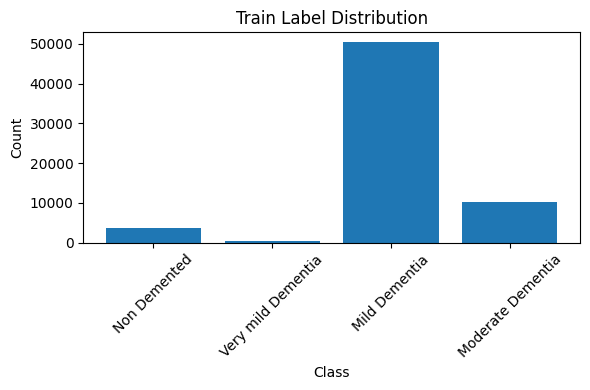

In [39]:
import matplotlib.pyplot as plt


def plot_counts(counts, title):
    labels = list(counts.keys())
    values = list(counts.values())
    class_names = list(dataset.class_to_idx.keys())

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values)
    plt.xticks(labels, class_names, rotation=45)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


plot_counts(train_counts, "Train Label Distribution")

To Handle the current imbalance i will use `WeightedRandomSampler`. But how would i get the weights?? 
what does that function even do??

Here's a study of this blog post [Demystifying PyTorch’s WeightedRandomSampler by example](https://medium.com/data-science/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452)


The first thing that we need to do is to calculate the weights that will be used to sample each image;
from the docs, we can see that we need a weight for each image in the dataset. 
In my opinion, the most confusing part about this is that these weights do not have to sum to 1. 
In reality, these weights represent the probability that an image will be selected, 
PyTorch simply scales these into [0, 1] range behind the scenes for convenience.


To get these weights we simply do a 1\(class counts), which ensures that classes with lowest representation will have the biggest weight.

In [61]:
import numpy as np


def get_sample_weights(dataset, train_dataset):
    y_train_indices = train_dataset.indices
    y_train = [dataset.targets[i] for i in y_train_indices]

    class_sample_counts = np.array(
        [len(np.where(y_train == t)[0]) for t in np.unique(y_train)]
    )

    weights = 1.0 / class_sample_counts
    sample_weights = np.array([weights[t] for t in y_train])
    sample_weights = torch.from_numpy(sample_weights)

    return sample_weights, class_sample_counts


sample_weights, class_counts = get_sample_weights(dataset, train_dataset)

sample_weights, class_counts

(tensor([1.9865e-05, 1.9865e-05, 1.9865e-05,  ..., 1.9865e-05, 1.9865e-05,
         2.6274e-04], dtype=torch.float64),
 array([ 3806,   365, 50341, 10315]))

In [64]:
min_class_size = class_counts.min()
num_classes = len(class_counts)

num_samples_per_epoch = min_class_size * num_classes

train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights, num_samples=int(num_samples_per_epoch), replacement=True
)

train_sampler

In [65]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
)


In [68]:
# Now let's visualize the balanced distribution by sampling from the DataLoader
def visualize_sampled_distribution(loader, num_samples=None):
    """
    Sample from the DataLoader and count class distribution

    Args:
        loader: DataLoader with sampler
        num_samples: Number of samples to check (default: one full epoch)
    """
    if num_samples is None:
        num_samples = len(loader.dataset)

    sampled_labels = []
    samples_collected = 0

    # Collect labels from the sampler
    for _, labels in loader:
        sampled_labels.extend(labels.tolist())
        samples_collected += len(labels)
        if samples_collected >= num_samples:
            break

    # Truncate to exact number if we oversampled
    sampled_labels = sampled_labels[:num_samples]

    return Counter(sampled_labels)


# Get the sampled distribution
sampled_counts = visualize_sampled_distribution(train_loader)
print("Sampled distribution:", sampled_counts)

Sampled distribution: Counter({1: 386, 2: 374, 0: 371, 3: 329})


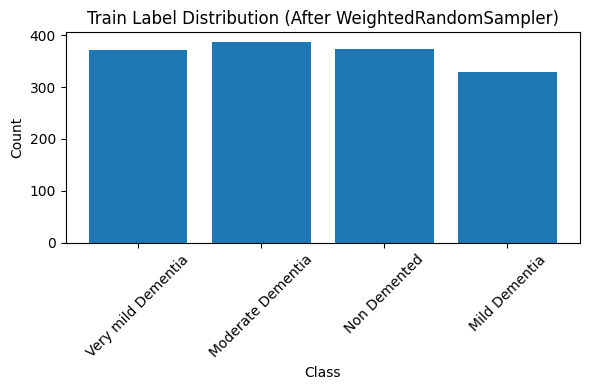

In [69]:
plot_counts(sampled_counts, "Train Label Distribution (After WeightedRandomSampler)")


Now all the classes are balanced as you see 

In [70]:
# Lets create the val and test loaders

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    drop_last=False,  # Drops the last data batch if it is not === batch_size
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    drop_last=True,
)

test_loader, val_loader

(<torch.utils.data.dataloader.DataLoader at 0x758db2a815a0>,
 <torch.utils.data.dataloader.DataLoader at 0x758da3fa4640>)

Letsgoo now we can finally create our model

In [71]:
model = torchvision.models.efficientnet_b0(
    weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [73]:
for param in model.features.parameters():
    param.requires_grad = False

In [74]:
model.classifier = nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=4, bias=True),
).to(device)

In [75]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 (864)
│    │    └─BatchNorm2d: 3-2                            (64)
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 (1,448)
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-5                                 (6,004)
│    │    └─MBConv: 3-6                                 (10,710)
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-7                                 (15,350)
│    │    └─MBConv: 3-8                                 (31,290)
│    └─Sequential: 2-5                                  --
│    │    └─MBConv

In [76]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

In [77]:
from tqdm import tqdm


def sanity_check(model, train_loader, loss_fn, optimizer, device, num_iterations=100):
    """
    Try to overfit on a single batch to verify the model can learn
    """
    model.train()

    # Get a single batch
    X_batch, y_batch = next(iter(train_loader))
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    losses = []
    accuracies = []

    for i in tqdm(range(num_iterations)):
        # Forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        preds = torch.argmax(y_pred, dim=1)
        accuracy = (preds == y_batch).float().mean().item()

        losses.append(loss.item())
        accuracies.append(accuracy)

        # Print progress
        if (i + 1) % 10 == 0 or i == 0:
            print(
                f"Iter [{i + 1}/{num_iterations}] - Loss: {loss.item():.4f}, Acc: {accuracy:.4f}"
            )

    print()
    print("=" * 70)

    # Check if model learned
    final_loss = losses[-1]
    final_acc = accuracies[-1]

    print(f"   Final Loss: {final_loss:.4f}, Final Acc: {final_acc:.4f}")

    print("=" * 70)

    # Plot the learning curve
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(losses)
    axes[0].set_title("Loss over iterations")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True)

    axes[1].plot(accuracies)
    axes[1].set_title("Accuracy over iterations")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Accuracy")
    axes[1].grid(True)
    axes[1].set_ylim([0, 1.05])

    plt.tight_layout()
    plt.show()

    return losses, accuracies


In [78]:
from sklearn.metrics import f1_score, accuracy_score


def train(model, train_loader, loss_fn, optimizer, device, epoch, num_epochs):
    model.train()

    train_loss = 0
    all_preds = []
    all_labels = []

    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = torch.argmax(y_pred, dim=1)  # Get class predictions
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    avg_loss = train_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")  # or 'macro', 'micro'

    print(
        f"Epoch [{epoch}/{num_epochs}] - Loss: {avg_loss:.4f}, Acc: {accuracy:.4f}, F1: {f1:.4f}"
    )

    return avg_loss, accuracy, f1

In [79]:
def validate(model, val_loader, loss_fn, device):
    model.eval()

    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()

            preds = torch.argmax(y_pred, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = val_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return avg_loss, accuracy, f1

In [81]:
def training_loop(
    model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs
):
    history = {
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
    }

    for epoch in tqdm(range(1, num_epochs + 1)):
        # Train
        train_loss, train_acc, train_f1 = train(
            model, train_loader, loss_fn, optimizer, device, epoch, num_epochs
        )

        # Validate
        val_loss, val_acc, val_f1 = validate(model, val_loader, loss_fn, device)

        print(f"Val - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}\n")

        # Store metrics
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

    return history


Running sanity check...


  1%|          | 1/100 [00:01<02:55,  1.77s/it]

Iter [1/100] - Loss: 1.4033, Acc: 0.2188


 10%|█         | 10/100 [00:18<02:56,  1.96s/it]

Iter [10/100] - Loss: 1.1001, Acc: 0.7396


 20%|██        | 20/100 [00:33<02:00,  1.51s/it]

Iter [20/100] - Loss: 0.8485, Acc: 0.8438


 30%|███       | 30/100 [00:52<02:18,  1.99s/it]

Iter [30/100] - Loss: 0.7048, Acc: 0.8854


 40%|████      | 40/100 [01:07<01:33,  1.56s/it]

Iter [40/100] - Loss: 0.5659, Acc: 0.9271


 50%|█████     | 50/100 [01:26<01:47,  2.14s/it]

Iter [50/100] - Loss: 0.4886, Acc: 0.9479


 60%|██████    | 60/100 [01:42<01:01,  1.54s/it]

Iter [60/100] - Loss: 0.4460, Acc: 0.9479


 70%|███████   | 70/100 [02:00<01:04,  2.14s/it]

Iter [70/100] - Loss: 0.3267, Acc: 0.9896


 80%|████████  | 80/100 [02:15<00:30,  1.54s/it]

Iter [80/100] - Loss: 0.3270, Acc: 0.9792


 90%|█████████ | 90/100 [02:34<00:24,  2.44s/it]

Iter [90/100] - Loss: 0.2537, Acc: 0.9896


100%|██████████| 100/100 [02:50<00:00,  1.71s/it]

Iter [100/100] - Loss: 0.2714, Acc: 0.9896

   Final Loss: 0.2714, Final Acc: 0.9896


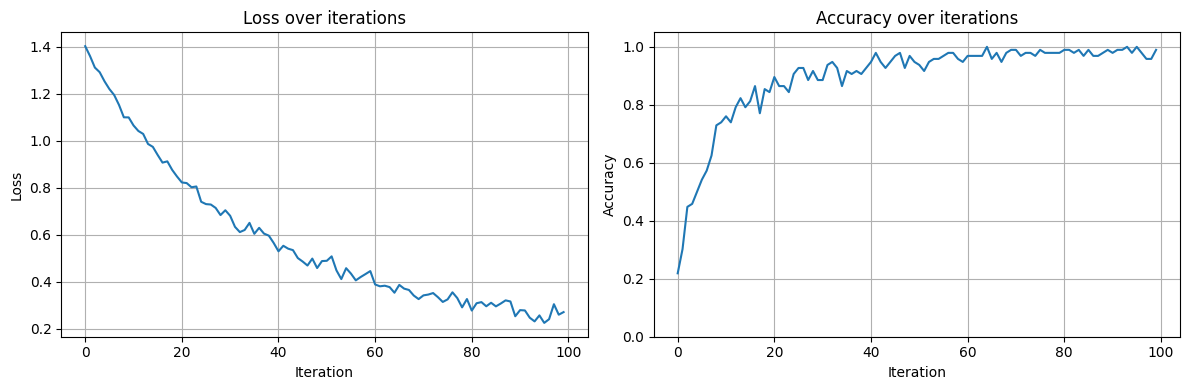

In [55]:
print("Running sanity check...")
losses, accs = sanity_check(
    model, train_loader, loss_fn, optimizer, device, num_iterations=100
)


In [82]:
history = training_loop(
    model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=10
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10] - Loss: 1.3432, Acc: 0.3404, F1: 0.3391


 10%|█         | 1/10 [02:15<20:22, 135.84s/it]

Val - Loss: 1.2567, Acc: 0.5841, F1: 0.6123

Epoch [2/10] - Loss: 1.1906, Acc: 0.5212, F1: 0.4801


 20%|██        | 2/10 [04:11<16:29, 123.70s/it]

Val - Loss: 1.2746, Acc: 0.5093, F1: 0.5664

Epoch [3/10] - Loss: 1.1007, Acc: 0.5753, F1: 0.5651


 30%|███       | 3/10 [06:06<14:00, 120.07s/it]

Val - Loss: 1.1440, Acc: 0.5990, F1: 0.6194

Epoch [4/10] - Loss: 1.0821, Acc: 0.5781, F1: 0.5699


 40%|████      | 4/10 [08:33<13:03, 130.60s/it]

Val - Loss: 1.0365, Acc: 0.6804, F1: 0.6698

Epoch [5/10] - Loss: 0.9905, Acc: 0.6370, F1: 0.6299


 50%|█████     | 5/10 [11:06<11:34, 138.83s/it]

Val - Loss: 1.0662, Acc: 0.6334, F1: 0.6579

Epoch [6/10] - Loss: 0.9788, Acc: 0.6192, F1: 0.6059


 60%|██████    | 6/10 [13:03<08:44, 131.13s/it]

Val - Loss: 0.8804, Acc: 0.7056, F1: 0.7109

Epoch [7/10] - Loss: 0.9347, Acc: 0.6493, F1: 0.6468


 70%|███████   | 7/10 [15:05<06:24, 128.25s/it]

Val - Loss: 0.7874, Acc: 0.7158, F1: 0.7157

Epoch [8/10] - Loss: 0.9270, Acc: 0.6397, F1: 0.6284


 80%|████████  | 8/10 [17:07<04:12, 126.41s/it]

Val - Loss: 0.6703, Acc: 0.7506, F1: 0.7552

Epoch [9/10] - Loss: 0.9008, Acc: 0.6651, F1: 0.6604


 90%|█████████ | 9/10 [19:07<02:04, 124.24s/it]

Val - Loss: 0.7563, Acc: 0.7069, F1: 0.7443

Epoch [10/10] - Loss: 0.8624, Acc: 0.6911, F1: 0.6845


100%|██████████| 10/10 [21:09<00:00, 126.91s/it]

Val - Loss: 0.8289, Acc: 0.6722, F1: 0.7180



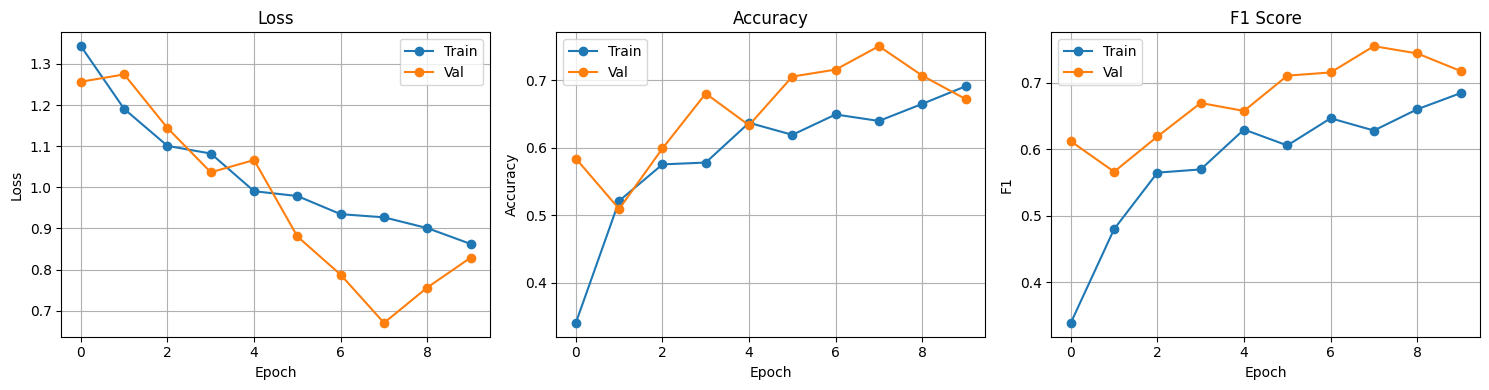

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history["train_loss"], label="Train", marker="o")
axes[0].plot(history["val_loss"], label="Val", marker="o")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history["train_acc"], label="Train", marker="o")
axes[1].plot(history["val_acc"], label="Val", marker="o")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True)

# F1 Score
axes[2].plot(history["train_f1"], label="Train", marker="o")
axes[2].plot(history["val_f1"], label="Val", marker="o")
axes[2].set_title("F1 Score")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("F1")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [85]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    !pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter


# Create a writer with all default settings
writer = SummaryWriter(log_dir="../experiments/run1")

In [86]:
for epoch in range(len(history["train_loss"])):
    writer.add_scalar("Loss/Train", history["train_loss"][epoch], epoch + 1)
    writer.add_scalar("Loss/Val", history["val_loss"][epoch], epoch + 1)

    writer.add_scalar("Accuracy/Train", history["train_acc"][epoch], epoch + 1)
    writer.add_scalar("Accuracy/Val", history["val_acc"][epoch], epoch + 1)

    writer.add_scalar("F1/Train", history["train_f1"][epoch], epoch + 1)
    writer.add_scalar("F1/Val", history["val_f1"][epoch], epoch + 1)

writer.close()


In [88]:
torch.save(model.state_dict(), "../models/run1.pth")
